Problem: Prediction of empathy score using dataset provided by eye tracking device
data set is of 60 participants
Two groups- control group and test group(502 data set approximately 10 trails of each participants)
Empaty score is given based on Questionaier analysis and is used for training and testing
The prediction of empathy score has been using regression model. 
Target value prediction has been done based on selected features using training and testing of different models linear regression model, random forest regressor . 
Evaluation is done based on RMSE and r2

In [26]:
# mount google drive to access the loaded data files 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# Libraries for data cleaning and feature extraction
import pandas as pd # for dataframe work 
import numpy as np
import os # for accessing files from the folder
import glob # to access files expansion and pattern matching csv
import re # To set of rules used to match patterns in strings

pd.set_option('max_colwidth', 100) # maximize column length
# ploting graphs
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import missingno as msno
# Libraries related to training and testing models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error




## **Testing DatasetII(Foraging Visual Information )**
     

*   For control and test data set.
*   Data Loading



In [28]:
# function created for file extraction from a folder 
# files extracted from control and test groups seperately
#extracted one file at a time to preprocess it 
# later on files are combined as per perticipants and trials

def preprocessing(data_set_2):
  data_clean=[]
  pattern = re.compile('[A-Za-z]+(\d+)') # used to change pattern of the data stored in the participant column 

# Function to extract the numeric part and convert to integer
  def convert_to_int(value):
    #value.astype(float)
    match = pattern.match(value)
    if match:
        return int(match.group(1))
    else:
        return None

  data_set_2['Participant name'] =data_set_2['Participant name'].apply(lambda x: convert_to_int(x)) # function called to change alphanumeric value to int. 
  data_set_2['Recording name'] =data_set_2['Recording name'].apply(lambda x: convert_to_int(x))    #function called to change alphanumeric value to int                        
  #print(data_set_2['Participant name'])
  data_set_2_new=data_set_2[['Participant name','Recording name','Recording duration', 'Pupil diameter left',
                            'Pupil diameter right','Eye position left X (DACSmm)',
                            'Eye position left Y (DACSmm)', 'Eye position left Z (DACSmm)',
                            'Eye position right X (DACSmm)', 'Eye position right Y (DACSmm)',
                            'Eye position right Z (DACSmm)', 'Gaze point left X (DACSmm)',
                            'Gaze point left Y (DACSmm)', 'Gaze point right X (DACSmm)',
                            'Gaze point right Y (DACSmm)',  
                            'Gaze event duration',
                            'Fixation point X', 'Fixation point Y',
                           
       
        ]].copy() # Only relevent feature are selected from the large columns
# Based on literature 
  data_set_2_new=data_set_2_new.astype(str)      
  cols = data_set_2_new.columns
  
  for col in cols :
    
    data_set_2_new[col] = data_set_2_new[col].apply(lambda x: float(x.split()[0].replace(',' or '"', '').replace("'", '')))
 
  Participant_name=data_set_2_new['Participant name'].iloc[0]
  Recording_name=data_set_2_new['Recording name'].iloc[0]

  Recording_duration= data_set_2_new['Recording duration'].astype(float).dropna().mean()
#Increase and decrease in pupil diameter gives variation in emotional arousal and regulation respectively.  
  Pupil_diameter_left= data_set_2_new['Pupil diameter left'].astype(float).dropna().std()
  Pupil_diameter_right=data_set_2_new['Pupil diameter right'].astype(float).dropna().std()
# Eye position features selected as it represent 3D position of right eye/left eyes, coordinates to analyse the variation in eye moment
  Eye_position_left_X =data_set_2_new['Eye position left X (DACSmm)'].astype(float).dropna().std()
  Eyeposition_left_Y=data_set_2_new['Eye position left Y (DACSmm)'].astype(float).dropna().std()
  Eyeposition_left_Z=data_set_2_new['Eye position left Z (DACSmm)'].astype(float).dropna().std()
  Eyeposition_right_X=data_set_2_new['Eye position right X (DACSmm)'].astype(float).dropna().std()
  Eyeposition_right_Y=data_set_2_new['Eye position right Y (DACSmm)'].astype(float).dropna().std()
  Eyeposition_right_Z=data_set_2_new['Eye position right Z (DACSmm)'].astype(float).dropna().std()
  
# Raw gaze coordinates of left  eye directly related to saccades.  

  Gaze_point_left_X=data_set_2_new['Gaze point left X (DACSmm)'].astype(float).dropna().std()
  Gaze_point_left_Y=data_set_2_new['Gaze point left Y (DACSmm)'].astype(float).dropna().std()
  Gaze_point_right_X=data_set_2_new['Gaze point right X (DACSmm)'].astype(float).dropna().std()
  Gaze_point_right_Y=data_set_2_new['Gaze point right Y (DACSmm)'].astype(float).dropna().std()
 
  Gaze_event_duration=data_set_2_new['Gaze event duration'].astype(float).dropna().mean()
# Fixation point features selected as it Coordinate of the ﬁxation point, and is related to focus

  Fixation_point_X=data_set_2_new['Fixation point X'].astype(float).dropna().std()
  Fixation_point_Y=data_set_2_new['Fixation point Y'].astype(float).dropna().std()
  

  data_clean=[Participant_name, Recording_name,Recording_duration,Pupil_diameter_left,Pupil_diameter_right,Eye_position_left_X,Eyeposition_left_Y,
  Eyeposition_left_Z,  Eyeposition_right_X,  Eyeposition_right_Y,  Eyeposition_right_Z, Gaze_point_left_Y, Gaze_point_right_X,Gaze_point_right_Y,Gaze_event_duration,Fixation_point_X,Fixation_point_Y ] 
  
  

  #print(data_clean)
  return(data_clean)


In [29]:

# read all the csv files(provided in EyeT, having data from two experiments)
# preprocessing function is called for each participant for trial
# Uisng os joined the directory of the folders to access the file
GOOGLE_DRIVE = os.path.join('/content/drive/MyDrive/Colab_Notebooks/CE887_Assinment2','EyeT_control')
GOOGLE_DRIVE_PATH = os.path.join('gdrive', 'MyDrive', GOOGLE_DRIVE)
path = GOOGLE_DRIVE_PATH
files = glob.glob(path + "/*.csv")
#print('List files: ', os.listdir(GOOGLE_DRIVE_PATH))
#files = glob.glob(path + 'EyeT_group_dataset_II_image_name_grey_blue_participant_2_trial_0.csv')
# all the csv files for foraging visual information are read for each participant one by one
#loop all the trials of the participants 
data_set_2_new=[]
for file in files:

  temp_df= pd.read_csv(file)

  rows_values =preprocessing(temp_df)
  data_set_2_new.append(rows_values)
#print(data_set_2_new)
data_set_2_new=pd.DataFrame(data_set_2_new, columns=['Participant_name',' Recording_name','Recording_duration','Pupil_diameter_left','Pupil_diameter_right','Eye_position_left_X','Eyeposition_left_Y',
  'Eyeposition_left_Z',  'Eyeposition_right_X',  'Eyeposition_right_Y',  'Eyeposition_right_Z', 'Gaze_point_left_Y', 'Gaze_point_right_X','Gaze_point_right_Y','Gaze_event_duration','Fixation_point_X','Fixation_point_Y' ] 
  )
data_set_2_new
  


,Participant_name,Recording_name,Recording_duration,Pupil_diameter_left,Pupil_diameter_right,Eye_position_left_X,Eyeposition_left_Y,Eyeposition_left_Z,Eyeposition_right_X,Eyeposition_right_Y,Eyeposition_right_Z,Gaze_point_left_Y,Gaze_point_right_X,Gaze_point_right_Y,Gaze_event_duration,Fixation_point_X,Fixation_point_Y
0,2.0,3.0,15290.0,23.339197,23.624382,26.289765,30.659082,65.547364,26.710477,30.889695,68.989758,416.009422,491.909553,421.364620,344.344288,145.847951,140.723036
1,2.0,2.0,14124.0,37.062704,38.000512,13.835210,21.907096,52.066492,12.994557,40.110737,92.741192,821.904984,672.438901,788.613108,187.437710,272.584078,265.297240
2,2.0,1.0,106276.0,28.410586,31.755974,173.271157,130.804149,703.028336,184.203677,118.112399,688.055961,590.999461,682.575490,576.617707,168.958310,238.950204,215.143706
3,2.0,5.0,228445.0,31.922357,36.108211,167.313875,91.684718,515.916297,167.680651,84.884742,489.860351,715.151485,1007.238732,709.856208,145.901685,362.807135,261.727667
4,2.0,3.0,15290.0,23.339197,23.624382,26.289765,30.659082,65.547364,26.710477,30.889695,68.989758,416.009422,491.909553,421.364620,344.344288,145.847951,140.723036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,58.0,4.0,64514.0,29.261258,48.595943,7.631225,11.029805,29.133835,6.237594,15.830277,39.337896,382.764523,654.670160,372.697845,519.913815,224.441603,135.249266
138,60.0,1.0,66391.0,15.064031,13.510603,9.580336,30.413749,77.400273,11.231990,28.067403,68.488096,382.081148,644.485840,400.709885,262.098980,190.756229,139.365494
139,60.0,2.0,63772.0,12.452552,13.156247,9.151951,19.846316,51.923110,10.903506,24.061692,63.103342,597.824053,672.435169,594.593528,349.377544,230.432093,212.904107
140,60.0,3.0,63924.0,15.212443,15.938389,10.289058,29.305418,78.563452,11.251189,26.477732,68.097060,401.528790,674.100587,420.726822,362.913344,195.445856,148.097968


In [30]:
# paticipant name converted to int
# information about the columns are displayed
data_set_2_new['Participant_name']=(data_set_2_new['Participant_name']).astype(int)
data_set_2_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Participant_name      142 non-null    int64  
 1    Recording_name       142 non-null    float64
 2   Recording_duration    142 non-null    float64
 3   Pupil_diameter_left   142 non-null    float64
 4   Pupil_diameter_right  142 non-null    float64
 5   Eye_position_left_X   142 non-null    float64
 6   Eyeposition_left_Y    142 non-null    float64
 7   Eyeposition_left_Z    142 non-null    float64
 8   Eyeposition_right_X   142 non-null    float64
 9   Eyeposition_right_Y   142 non-null    float64
 10  Eyeposition_right_Z   142 non-null    float64
 11  Gaze_point_left_Y     142 non-null    float64
 12  Gaze_point_right_X    142 non-null    float64
 13  Gaze_point_right_Y    142 non-null    float64
 14  Gaze_event_duration   142 non-null    float64
 15  Fixation_point_X      1

In [31]:
#Access questionnair file 
# column renamed as this file need to merge with eyetracking file
#path2 = r'/content/drive/MyDrive/Colab_Notebooks/CE887_Assinment2/Questionnaire_datasetIB.csv'
Empathy=pd.read_csv(r'/content/drive/MyDrive/Colab_Notebooks/CE887_Assinment2/Questionnaire_datasetIB_N.csv', encoding='cp1252')
Empathy.rename(columns={'Participant name': 'Participant_name'})
Empathy.info()
#Empathy['Participant_name']=(Empathy['Participant_name']).astype(float)
#Empathy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Participant_name      60 non-null     int64
 1   Total Score original  60 non-null     int64
dtypes: int64(2)
memory usage: 1.1 KB


In [32]:
# merging empathy score with the features extracted from the each trials of respective participants
df_merged = pd.merge(data_set_2_new, Empathy, on='Participant_name')
df1=df_merged
df1.columns
#print(df1)

Index(['Participant_name', ' Recording_name', 'Recording_duration',
       'Pupil_diameter_left', 'Pupil_diameter_right', 'Eye_position_left_X',
       'Eyeposition_left_Y', 'Eyeposition_left_Z', 'Eyeposition_right_X',
       'Eyeposition_right_Y', 'Eyeposition_right_Z', 'Gaze_point_left_Y',
       'Gaze_point_right_X', 'Gaze_point_right_Y', 'Gaze_event_duration',
       'Fixation_point_X', 'Fixation_point_Y', 'Total Score original'],
      dtype='object')

In [33]:
#Features selected for predicting empathy
#drop Participant number and trial number before trainig model
df2=df1.drop(['Participant_name'], axis=1) 
df1_new=df2.drop([' Recording_name'], axis=1) 

Feature Understanding
"""From the literature study  *****
Statistical features of eye gaze trajectories reflects empathy
and fixation and saccade analysis can be done 
pupil dilation represents empathy due to change in size of pupil(like change in size due to stress or anxiety)"""

In [34]:
# Targeted empathy score is seperated from all other features
# For control dataset we have 142 columns
Y=df1_new['Total Score original']
X=df1_new.drop(['Total Score original'], axis=1)
print(X.shape)
print(Y.shape)

(142, 15)
(142,)


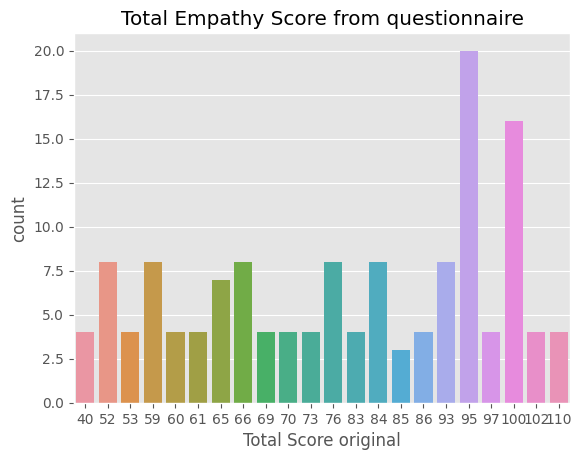

In [35]:
#Empathy score from questionnaire set B
#shows the distribution of counts for each empathy score in a sample of trials
# Around 25% count appear between range 95 to 100
sns.countplot(x='Total Score original', data=df1_new)
plt.title('Total Empathy Score from questionnaire')
plt.show()

In [36]:
#data is splitted into train and test
# 70% data used for traing model and 30% data used for testing
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [37]:

# Create a regression model, as it performs well to have insights of input features
model = LinearRegression()
# Train the model on the training data
model.fit(X_train, Y_train)
# predict the data for X test samples
Y_pred = model.predict(X_test)
mse_lr = mean_squared_error(Y_test, Y_pred)
# as the errors can be positive or negative therefore mean square erroe is calculated    
print(f"MSE = {mse_lr}")


MSE = 354.34517083135654


In [38]:
# Calculate root mean squared error
from sklearn.metrics import mean_squared_error
rmse_lr = np.sqrt(mean_squared_error(Y_test, Y_pred))
print('RMSE for data set II on model Linear regration:', rmse_lr)
# To evaluate the regration model performance r2 score is used
from sklearn.metrics import r2_score
r2_lr = r2_score(Y_test, Y_pred)
# Print the R-squared value
print("r2 score for Control data set", r2_lr) # results showed that model is not suitable for the given data
#print(Y_pred)
#print(Y_test)

RMSE for data set II on model Linear regration: 18.824058298660162
r2 score for Control data set -0.10928971387894726


In [39]:
# Random Forest Model for Test Data Set
# This model suitable for large features and large data
# good for outliers
from sklearn.ensemble import RandomForestRegressor
model_RF = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
model_RF.fit(X_train, Y_train)
Y_pred_RF = model_RF.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred_RF)
# as the errors can be positive or negative therefore mean square erroe is calculated
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred_RF))
print('Root Mean Squared Error of Control data set:', rmse)
r2_RF = r2_score(Y_test, Y_pred_RF)
# Print the R-squared value
print("R-squared for data set III on Random Forest model :", r2_RF) # gor 0.337 r2 value which is better than linear regression model
#print(Y_pred)
#print(Y_test) # results showed that model is  suitable for the given data

Root Mean Squared Error of Control data set: 14.554998455558854
R-squared for data set III on Random Forest model : 0.3368026305691819


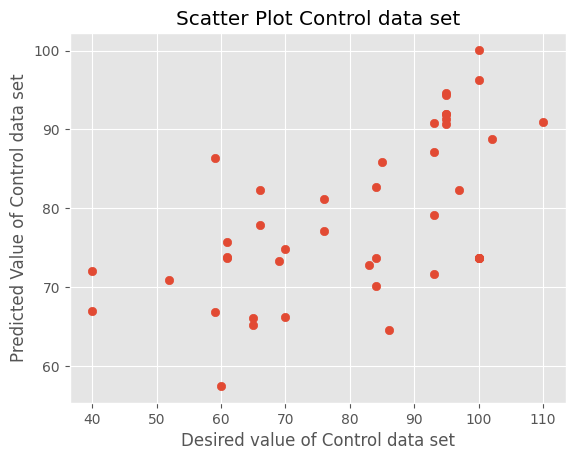

In [40]:
#illustrates the difference between the empathy score given by questionnaire and the predicted scores by the trained models
plt.scatter(Y_test, Y_pred_RF)
# Plots graphs with proper label and title
plt.title('Scatter Plot Control data set')
plt.xlabel('Desired value of Control data set')
plt.ylabel('Predicted Value of Control data set')
plt.show()

## **Testing the DataSetIII(Visual Communication)**

In [41]:

# read all the csv files(provided in EyeT, having data from two experiments)
GOOGLE_DRIVE_T = os.path.join('/content/drive/MyDrive/Colab_Notebooks/CE887_Assinment2','EyeT_test')
GOOGLE_DRIVE_PATH_T = os.path.join('gdrive', 'MyDrive', GOOGLE_DRIVE_T)
Path = GOOGLE_DRIVE_PATH_T
Files_T = glob.glob(Path + "/*.csv")

# all the csv files for Visual Communication are read for each participant one by one
#loop all the trials of the participants 
data_set_2_new_T=[]
for file in Files_T:

  temp_df_T= pd.read_csv(file)

  rows_values_T =preprocessing(temp_df_T)
  data_set_2_new_T.append(rows_values_T)
#print(data_set_2_new)
data_set_2_new_T=pd.DataFrame(data_set_2_new_T, columns=['Participant_name',' Recording_name','Recording_duration','Pupil_diameter_left','Pupil_diameter_right','Eye_position_left_X','Eyeposition_left_Y',
  'Eyeposition_left_Z',  'Eyeposition_right_X',  'Eyeposition_right_Y',  'Eyeposition_right_Z', 'Gaze_point_left_Y', 'Gaze_point_right_X','Gaze_point_right_Y','Gaze_event_duration','Fixation_point_X','Fixation_point_Y' ] )
data_set_2_new_T
  

<ipython-input-41-23c41df48219>:12: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df_T= pd.read_csv(file)
<ipython-input-41-23c41df48219>:12: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df_T= pd.read_csv(file)
<ipython-input-41-23c41df48219>:12: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df_T= pd.read_csv(file)
<ipython-input-41-23c41df48219>:12: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df_T= pd.read_csv(file)
<ipython-input-41-23c41df48219>:12: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df_T= pd.read_csv(file)
<ipython-input-41-23c41df48219>:12: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  tem

,Participant_name,Recording_name,Recording_duration,Pupil_diameter_left,Pupil_diameter_right,Eye_position_left_X,Eyeposition_left_Y,Eyeposition_left_Z,Eyeposition_right_X,Eyeposition_right_Y,Eyeposition_right_Z,Gaze_point_left_Y,Gaze_point_right_X,Gaze_point_right_Y,Gaze_event_duration,Fixation_point_X,Fixation_point_Y
0,1.0,2.0,73900.0,13.334846,15.434279,59.213772,70.456114,175.927395,60.510734,73.435743,188.026754,745.247185,842.106963,762.600540,151.752562,305.371286,296.290023
1,1.0,1.0,83579.0,15.053379,15.849782,94.036389,200.578491,353.876119,81.854422,228.025718,362.153291,803.727593,740.715580,812.160875,166.684796,267.885113,290.363388
2,1.0,5.0,72090.0,14.372641,14.841444,90.104280,50.305008,119.342875,88.340575,46.041057,123.627577,860.148002,834.165366,869.082890,154.653774,309.435446,326.989761
3,1.0,4.0,103283.0,12.187443,13.695663,48.209838,83.648636,143.676707,48.068860,81.748509,129.552034,797.531963,636.079398,798.207816,142.507026,230.804777,311.058266
4,1.0,3.0,64593.0,11.861816,13.594021,34.930673,15.615706,62.771354,34.901694,16.096203,57.923383,881.427067,746.261603,887.068164,134.797312,276.267425,335.302173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,59.0,5.0,147069.0,12.592268,14.220015,8.612465,13.829155,40.062818,9.901926,14.582657,44.478870,738.802602,685.658217,652.997755,232.454524,264.576522,186.516087
356,59.0,4.0,58938.0,14.815812,15.687924,8.489602,16.999280,47.521847,9.562547,12.975869,35.129394,693.005011,639.480390,561.652472,214.853881,255.027508,171.882013
357,59.0,6.0,195934.0,14.899210,16.246641,9.135264,17.779290,55.360227,12.110767,20.192872,63.908617,709.861661,746.954119,750.896495,234.686672,285.059601,171.713078
358,59.0,8.0,63470.0,19.516512,19.357976,11.493094,38.903189,118.509631,10.666786,23.018275,67.313001,771.153101,763.953402,664.344776,193.072732,292.281472,170.240429


In [42]:
#Features selected for predicting empathy
#drop Participant number and trial number before trainig model
data_set_2_new_T['Participant_name']=(data_set_2_new_T['Participant_name']).astype(int)
print(data_set_2_new_T.info())
# merging empathy score with the features extracted from the each trials of respective participants
df_merged_T = pd.merge(data_set_2_new_T, Empathy, on='Participant_name')

df1_T=df_merged_T
df1_T.columns
#print(df1)
df2_T=df1_T.drop(['Participant_name'], axis=1) 
df1_new_T=df2_T.drop([' Recording_name'], axis=1) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Participant_name      360 non-null    int64  
 1    Recording_name       360 non-null    float64
 2   Recording_duration    360 non-null    float64
 3   Pupil_diameter_left   360 non-null    float64
 4   Pupil_diameter_right  360 non-null    float64
 5   Eye_position_left_X   360 non-null    float64
 6   Eyeposition_left_Y    360 non-null    float64
 7   Eyeposition_left_Z    360 non-null    float64
 8   Eyeposition_right_X   360 non-null    float64
 9   Eyeposition_right_Y   360 non-null    float64
 10  Eyeposition_right_Z   360 non-null    float64
 11  Gaze_point_left_Y     360 non-null    float64
 12  Gaze_point_right_X    360 non-null    float64
 13  Gaze_point_right_Y    360 non-null    float64
 14  Gaze_event_duration   360 non-null    float64
 15  Fixation_point_X      3

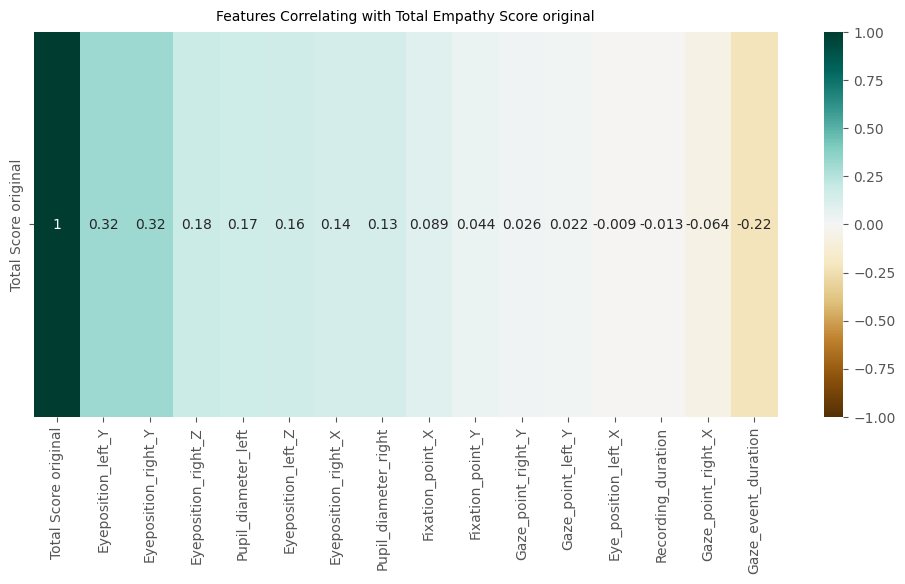

In [44]:
#Corelation of Independent Variables with the Dependent Variable using heatmap.
#the movement of eyes is highly correlated with the targeted output
#gaze event duration showed a high negative correlation with empathy scores
import seaborn as sns
df1_new_T.corr()
plt.figure(figsize=(12, 5))
heatmap = sns.heatmap(df1_new_T.corr()[['Total Score original']].sort_values(by='Total Score original', ascending=False).T, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Total Empathy Score original', fontdict={'fontsize':10}, pad=8);

In [45]:
#Testing and Training Model
Y_T=df1_new_T['Total Score original']
X_T=df1_new_T.drop(['Total Score original'], axis=1)
print(X_T.shape)
print(Y_T.shape)
from sklearn.model_selection import train_test_split
X_train_T, X_test_T, Y_train_T, Y_test_T = train_test_split(X_T, Y_T, test_size = 0.3, random_state = 42)


(360, 15)
(360,)


In [46]:
#  Create a regression model, as it performs well to have insights of input features
modelR = LinearRegression()    
# Train the model on the training data 
modelR.fit(X_train_T, Y_train_T)
Y_pred_T = modelR.predict(X_test_T)
mse_lr = mean_squared_error(Y_test_T, Y_pred_T)
# as the errors can be positive or negative therefore mean square erroe is calculated    
print(f"MSE = {mse_lr}")
rmse_lr_T = np.sqrt(mean_squared_error(Y_test_T, Y_pred_T))
print('Root Mean Squared Error of data set 3:', rmse_lr_T)
r2_lr_T = r2_score(Y_test_T, Y_pred_T)
# Print the R-squared value
print("R-squared for data set III on model Linear regration:", r2_lr_T)# gor 0.25 r2 value which is better than linear regression model for control group

MSE = 89.40329618841851
Root Mean Squared Error of data set 3: 9.455331627627796
R-squared for data set III on model Linear regration: 0.2510229148037071


In [47]:
# Random Forest Model for Test Data Set
# This model suitable for large features and large data
# good for outliers
from sklearn.ensemble import RandomForestRegressor
model_RF_T = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
model_RF_T.fit(X_train_T, Y_train_T)
Y_pred_RF_T = model_RF_T.predict(X_test_T)
mse_T = mean_squared_error(Y_test_T, Y_pred_RF_T)
# as the errors can be positive or negative therefore mean square erroe is calculated
rmse_T = np.sqrt(mean_squared_error(Y_test_T, Y_pred_RF_T))
print('Root Mean Squared Error of data set III:', rmse_T)
r2_RF_T = r2_score(Y_test_T, Y_pred_RF_T)
# Print the R-squared value
print("R-squared for test group:", r2_RF_T)# gor 0.686 r2 value which is better than linear regression model
#print(Y_pred)
#print(Y_test)

Root Mean Squared Error of data set III: 6.1191683452499
R-squared for test group: 0.686310629746701


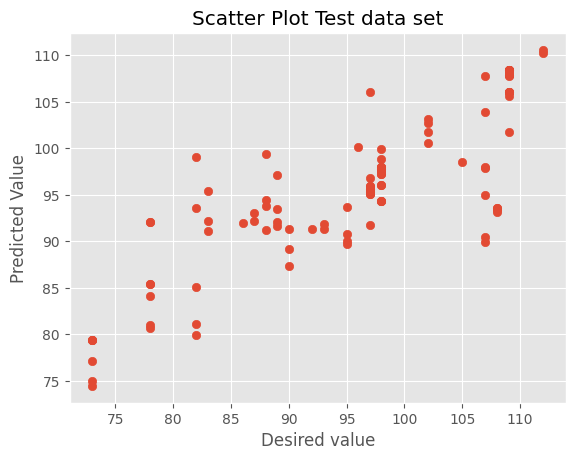

In [48]:
#illustrates the difference between the empathy score given by questionnaire and the predicted scores by the trained models
plt.scatter(Y_test_T, Y_pred_RF_T)
# Plots graphs with proper label and title
plt.title('Scatter Plot Test data set')
plt.xlabel('Desired value')
plt.ylabel('Predicted Value')
plt.show()

## **Performance of both the models**
## **Performance for both the groups**

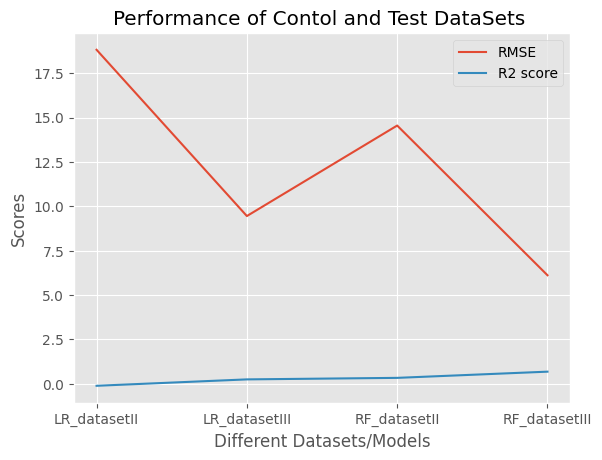

In [49]:
#plotting of graph
#illustrates that irrespective of ML models the data set III has better performance than data set II.
# Overall the random forest model worked well as compared to linear regression
y1_rms=[rmse_lr,rmse_lr_T,rmse,rmse_T]
r2_scr=[r2_lr,r2_lr_T,r2_RF,r2_RF_T]
x=['LR_datasetII','LR_datasetIII','RF_datasetII','RF_datasetIII']
plt.plot(x, y1_rms, label='RMSE')
plt.plot(x, r2_scr, label='R2 score')
# Plots graphs with proper label and title, including legends which distinguish lines
plt.xlabel('Different Datasets/Models')
plt.ylabel('Scores')
plt.title('Performance of Contol and Test DataSets ')
plt.legend()
# Show the graph
plt.show()